<center><b>Feature extraction per caratterizzazione stile di guida</b></center>

Ci occuperemo di estrarre dai dati valori di riferimento per caratterizzarne la guida di un pilota e di conseguenza riuscire a classficarlo. Comprenderanno velocità, accelerazioni, frenata (durata, intensità e trail-braking), traiettoria, marce ecc. 

First of all, let's import the computed data from *brakes_analysis.ipynb*

In [2]:
import pandas as pd  
#data of verstappen lap on suzuka
data = pd.read_pickle("data/merged_driverVER_lap1.pkl")
data.head()

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,...,X,Y,Z,s_m,kappa,lat_acc_smooth,v_ms,lat_acc_est,in_curve_est,decel
0,2024-04-07 06:51:47.546,11013.0,281.0,7,100.0,False,12,car,0 days 00:00:00.392000,0 days 02:50:45.912000,...,188.4,-105.7,73.5,0.000000,0.0,0.0,78.055556,0.0,0,NaN
1,2024-04-07 06:51:47.706,11264.0,284.0,7,100.0,False,12,car,0 days 00:00:00.552000,0 days 02:50:46.072000,...,200.5,-120.2,73.0,0.000000,0.0,0.0,78.888889,0.0,0,-5.208333
2,2024-04-07 06:51:48.186,11528.0,289.0,7,100.0,False,12,car,0 days 00:00:01.032000,0 days 02:50:46.552000,...,215.1,-137.1,72.3,0.000000,0.0,0.0,80.277778,0.0,0,-2.893519
3,2024-04-07 06:51:48.385,11529.0,291.0,7,100.0,False,12,car,0 days 00:00:01.231000,0 days 02:50:46.751000,...,223.5,-146.9,72.0,19.915070,0.0,0.0,80.833333,0.0,0,-2.791736
4,2024-04-07 06:51:48.785,11438.0,294.0,7,100.0,False,12,car,0 days 00:00:01.631000,0 days 02:50:47.151000,...,259.6,-189.1,70.4,42.248229,0.0,0.0,81.666667,0.0,0,-2.083333


We want to produce a better vision on the brakes, not just 0-1 but a normalization of the values based on the telemetry. We can compare two methods: the first is *Decay smoothing*, the second is *rolling*

In [267]:
import numpy as np
import pandas as pd

def brake_norm_trail_deltaV_nocap(
    df,
    time_col='Time',
    brake_col='Brake',
    speed_col='Speed',

    # chiusura micro-buchi tra due True (s)
    close_gaps_s=0.12,

    # dinamica frenata
    tau_rise=0.04,
    tau_trail=0.38,

    # picco da ΔV (km/h)
    dv_low=6.0,
    dv_high=80.0,
    peak_low=0.35,
    peak_high=0.98,

    # min trail dinamico
    min_trail_lo=0.02,
    min_trail_hi=0.08,
):
    g = df.copy()

    # tempo assoluto -> datetime -> relativo (s)
    if not np.issubdtype(g[time_col].dtype, np.datetime64):
        g[time_col] = pd.to_datetime(g[time_col], errors='coerce')
    valid = g[time_col].notna()
    g = g.loc[valid].copy()
    t = (g[time_col] - g[time_col].iloc[0]).dt.total_seconds().to_numpy()

    # segnali
    br_raw = g[brake_col].astype(bool).to_numpy()

    v_raw = pd.to_numeric(g[speed_col], errors='coerce').fillna(method='ffill').fillna(0).to_numpy()
    # se la velocità sembra in m/s, porta a km/h per il calcolo di ΔV
    v = v_raw * (3.6 if np.nanmax(v_raw) < 60 else 1.0)

    n = len(br_raw)

    # --- 1) CHIUSURA MICRO-BUCHI (morfologia “closing” su tempo) ---
    br = br_raw.copy()
    # individua segmenti True
    segs = []
    i = 0
    while i < n:
        if not br[i]:
            i += 1
            continue
        j = i
        while j < n and br[j]:
            j += 1
        segs.append([i, j])  # [start, end)
        i = j
    # unisci segmenti separati da gap corti
    merged = []
    for s in segs:
        if not merged:
            merged.append(s); continue
        prev = merged[-1]
        gap = t[s[0]] - t[prev[1]-1]
        if gap <= close_gaps_s:
            prev[1] = s[1]  # fondi
        else:
            merged.append(s)
    # costruisci maschera chiusa
    br_closed = np.zeros_like(br, dtype=bool)
    for s, e in merged:
        br_closed[s:e] = True
    br = br_closed

    # --- 2) COSTRUISCI brake_norm per segmenti Brake=True ---
    out = np.zeros(n, dtype=float)
    i = 0
    while i < n:
        if not br[i]:
            i += 1
            continue
        j = i
        while j < n and br[j]:
            j += 1
        if j - i < 2:
            i = j
            continue

        seg_t = t[i:j]
        seg_rel = seg_t - seg_t[0]
        dur = float(seg_rel[-1])

        v_seg = v[i:j]
        dv = float(max(0.0, v_seg[0] - np.min(v_seg)))  # ΔV km/h

        # picco da ΔV + leggero boost con durata
        peak_base = np.interp(dv, [dv_low, dv_high], [peak_low, peak_high],
                              left=peak_low, right=peak_high)
        boost = 1.0 + 0.12 * min(1.0, dur/0.60)
        peak = float(np.clip(peak_base * boost, 0.0, 0.98))

        # shape normalizzata (attack*decay)
        attack = 1.0 - np.exp(-seg_rel / max(tau_rise, 1e-6))
        decay  = np.exp(-seg_rel / max(tau_trail, 1e-6))
        shape  = attack * decay
        smax = float(shape.max()) if shape.size else 1.0
        shape = shape / (smax if smax > 1e-6 else 1.0)
        # --- dopo aver calcolato dv e prima di costruire seg ---
        seg_idx = len([1 for s in range(n) if br[s] and (s == 0 or not br[s-1]) and s < i]) + 1  # 1-based
        if seg_idx == 3:  # SOLO terza frenata
            # alza il picco minimo e riempi un po' la campana
            peak = max(peak, 0.28)                 # soft floor ~28%
            shape = shape ** 1.25                  # curva più "piena"
            min_trail = max(min_trail, 0.04)       # trail minimo un filo più alto

        seg = peak * shape

        # min trail dinamico (basso se ΔV piccolo, più alto se ΔV grande)
        min_trail = np.interp(dv, [0.0, dv_low, dv_high], [min_trail_lo, 0.04, min_trail_hi])
        seg = np.maximum(seg, min_trail)

        out[i:j] = seg
        i = j

    result = np.zeros(len(df), dtype=float)
    result[valid.to_numpy()] = np.clip(out, 0.0, 1.0)
    return pd.Series(result, index=df.index, name='brake_norm')


In [276]:
data['brake_norm'] = brake_norm_trail_deltaV_nocap(
    data,
    time_col='Time',
    brake_col='Brake',
    speed_col='Speed',
    close_gaps_s=0.12,      # unisci buchi brevi nel brake
    tau_rise=0.04,
    tau_trail=0.38,
    dv_low=6, dv_high=80,
    peak_low=0.35, peak_high=0.98
)


C:\Users\fraba\AppData\Local\Temp\ipykernel_23632\2199162840.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  v_raw = pd.to_numeric(g[speed_col], errors='coerce').fillna(method='ffill').fillna(0).to_numpy()


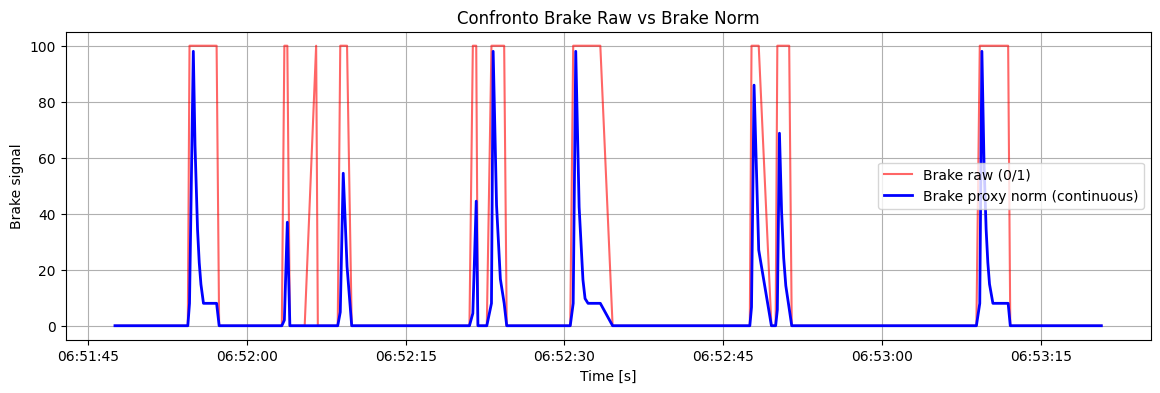

In [277]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,4))
plt.plot(data['Time'], data['Brake']*100, label='Brake raw (0/1)', color='red', alpha=0.6)
plt.plot(data['Time'], data['brake_norm']*100, label='Brake proxy norm (continuous)', color='blue', linewidth=2)
plt.xlabel('Time [s]')
plt.ylabel('Brake signal')
plt.title('Confronto Brake Raw vs Brake Norm')
plt.legend()
plt.grid(True)
plt.show()


Feature per descrivere il ritmo del giro:
- *lap_time*: durata totale del giro
- *avg_speed*, *max_speed*: velocità media e massima
- *avg_throttle*, *pct_full_throttle*: media della quantità di gas applicato e percentuale di tempo full-gas
- *pct_braking_time*: tempo con brake > 0
- *avg_brake_intensity*: media di brake_proxy_norm 
- *n_brake_events*: numero di frenate distinte

In [98]:
import fastf1
session = fastf1.get_session(2024, 'Suzuka', 'R')
session.load()

core           INFO 	Loading data for Japanese Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '4', '14', '63', '81', '44', '22', '27', '18', '20', '77', '31', '10', '2', '24', '3', '23']


In [99]:
#compute lap_time, avg_speed, avg_throttle, pct_fuSll_throttle
avg_speed = data['Speed'].mean().round(2)
avg_throttle = data['Throttle'].mean().round(2)
lap_time = data['Time'].iloc[-1] - data['Time'].iloc[0]
pct_full_throttle = ((data['Throttle'] == 100).sum() / len(data) * 100).round(2)
pct_braking = ((data['Brake'] > 0).sum() / len(data) * 100).round(2)
n_brakes = (data['Brake'].diff() == 1).sum()
print(f"average speed is {avg_speed}, average throttle pressure is {avg_throttle}%, \n best lap time is {lap_time}, full gas time percentage is {pct_full_throttle}%, \nbraking time percentage is {pct_braking}%, number of braking events is {n_brakes}")

average speed is 225.14, average throttle pressure is 69.95%, 
 best lap time is 0 days 00:01:33.160000, full gas time percentage is 55.49%, 
braking time percentage is 16.47%, number of braking events is 20


Now let's compute the dynamic features:
- Mean_decel and max_decel
- throttle_variability 
- trail_braking_ratio: braking with steering
- corner_exit_throttle_delay: time between brake release and gas

In [100]:
#dynamic features and transitions features
mean_decel = data.loc[data['brake_norm'] > 0, 'decel'].mean().round(2)
max_decel = data.loc[data['brake_norm'] > 0, 'decel'].max().round(2)
#variabikity of throttle during the lap
throttle_variability = (data['Throttle'] / 100).std().round(3)

lat_threshold = 0.3 * data['lat_acc_smooth'].max()
trail_braking_ratio = data.loc[(data['brake_norm'] > 0) & (data['lat_acc_smooth'] >= lat_threshold),'brake_norm'].mean().round(3)
trail_braking_pct = (
    len(data.loc[(data['brake_norm'] > 0) & (data['lat_acc_smooth'] >= lat_threshold)]) /
    len(data.loc[data['brake_norm'] > 0])
    )

features = {
    'mean_decel': mean_decel,
    'max_decel': max_decel,
    'throttle_variability': throttle_variability,
    'trail_braking_ratio': trail_braking_ratio,
    'trail_braking_pct': trail_braking_pct,
}

print(features)

{'mean_decel': np.float64(10.62), 'max_decel': np.float64(45.83), 'throttle_variability': np.float64(0.41), 'trail_braking_ratio': np.float64(0.672), 'trail_braking_pct': 0.7111111111111111}


We can now compute the mean time between a braking section and the moment the driver gets back on the gas (we can use a threshold of 0.05)

In [101]:
brake_threshold = 0.05
throttle_threshold = 0.10

# Convert timestamp
data['Time'] = pd.to_datetime(data['Date'])

# Identifica eventi di rilascio freno
data['brake_on'] = data['brake_norm'] > brake_threshold
data['brake_off_event'] = data['brake_on'].shift(1) & (~data['brake_on'])

release_times = data.loc[data['brake_off_event'], 'Time']

delta_times = []

# Per ogni rilascio freno cerca quando torna sul gas
for t0 in release_times:
    sub = data[data['Time'] > t0]
    throttle_on = sub[sub['Throttle'] > throttle_threshold]
    if not throttle_on.empty:
        t1 = throttle_on.iloc[0]['Time']
        delta_times.append((t1 - t0).total_seconds())

avg_reaction = np.mean(delta_times)
print("Tempo medio di transizione brake-throttle:", avg_reaction, "secondi")

Tempo medio di transizione brake-throttle: 0.5801999999999999 secondi


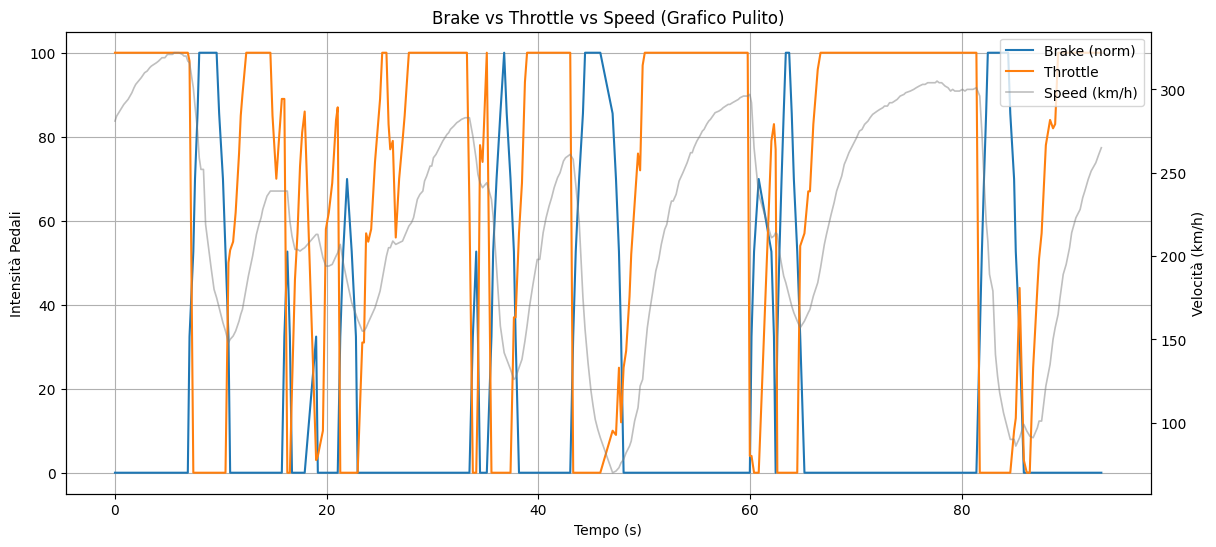

In [102]:
# Tempo relativo (in secondi)
data['t'] = (data['Time'] - data['Time'].iloc[0]).dt.total_seconds()

plt.figure(figsize=(14,6))

# Grafico Brake e Throttle
plt.plot(data['t'], data['brake_norm']*100, label='Brake (norm)', linewidth=1.5)
plt.plot(data['t'], data['Throttle'], label='Throttle', linewidth=1.5)

# Aggiungiamo Speed su un asse secondario
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(data['t'], data['Speed'], color='gray', alpha=0.5, linewidth=1.2, label='Speed (km/h)')

# Label e stile
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Intensità Pedali')
ax2.set_ylabel('Velocità (km/h)')

plt.title('Brake vs Throttle vs Speed (Grafico Pulito)')
ax1.grid(True)

# Legende unite
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.show()
